In [11]:

import torch
import torch.nn as nn
import torch.autograd as autograd
import matplotlib.pyplot as plt
# -----------------------------------------------------------------------------
# Set random seed & device
# -----------------------------------------------------------------------------
import csv
import time
from datetime import datetime
import os
torch.manual_seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")


Using cuda


In [3]:
# -----------------------------------------------------------------------------
# Problem constants & helper functions
# -----------------------------------------------------------------------------


# Network architecture: input (x,t) -> 64‑64‑64 hidden units -> output u
layers = [2,128, 128,128,128,128,128,128, 1]


class PINN(nn.Module):
    """Simple fully‑connected network with tanh activations."""

    def __init__(self, layers):
        super().__init__()
        blocks = []
        for l_in, l_out in zip(layers[:-2], layers[1:-1]):
            blocks.append(nn.Linear(l_in, l_out))
            blocks.append(nn.Tanh())
        blocks.append(nn.Linear(layers[-2], layers[-1]))
        self.model = nn.Sequential(*blocks)

        # Xavier (Glorot) initialisation for faster convergence
        for m in self.model:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x, t):
        """x, t: tensors of shape (N,1)"""
        input_pair = torch.cat([x, t], dim=1)
        return self.model(input_pair)


def pde_residual(model: nn.Module, x: torch.Tensor, t: torch.Tensor):
    """Compute residual f(x,t) = ∂u/∂t + a ∂u/∂x."""
    x.requires_grad_(True)
    t.requires_grad_(True)

    u = model(x, t)

    # ∂u/∂t
    u_t = autograd.grad(u, t,
                        grad_outputs=torch.ones_like(u),
                        create_graph=True)[0]
    # ∂u/∂x
    u_x = autograd.grad(u, x,
                        grad_outputs=torch.ones_like(u),
                        create_graph=True)[0]

    return u_t + a * u_x  # residual should be ≈ 0

In [4]:

def get_density(t):
    """
    Returns the density (as a PyTorch tensor) based on time t (in seconds).
    Supports scalar or batch tensor input.
    
    Parameters:
        t (torch.Tensor): Time(s) in seconds.
        
    Returns:
        torch.Tensor: Density (kg/m³), same shape as t.
    """
    t = torch.as_tensor(t, dtype=torch.float32)
    cycle_position = torch.floor(t / 300).to(torch.int32)
    
    # Even cycles → water (1000), Odd cycles → phosphate (1800)
    density = torch.where(cycle_position % 2 == 0,
                          torch.tensor(1),
                          torch.tensor(1.6))
    return density



def get_viscosity(t):
    """
    Returns the density (as a PyTorch tensor) based on time t (in seconds).
    Supports scalar or batch tensor input.
    
    Parameters:
        t (torch.Tensor): Time(s) in seconds.
        
    Returns:
        torch.Tensor: Density (kg/m³), same shape as t.
    """
    t = torch.as_tensor(t, dtype=torch.float32)
    cycle_position = torch.floor(t / 360).to(torch.int32)
    # Even cycles → water (1000), Odd cycles → phosphate (1800)
    # Mu = 1.6 for water, Mu = 1 for phosphate

    Mu = torch.where(cycle_position % 2 == 0,
                          torch.tensor(1),
                          torch.tensor(0.01))
    return Mu
    # return Mu


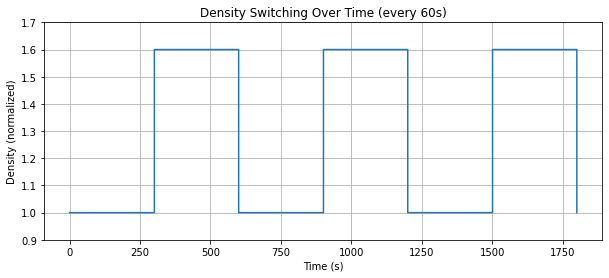

In [5]:
# Generate time values from 0 to 600 seconds
t_values = torch.linspace(0, 1800, steps=1000)
density_values = get_density(t_values)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(t_values, density_values, drawstyle='steps-post')
plt.xlabel("Time (s)")
plt.ylabel("Density (normalized)")
plt.title("Density Switching Over Time (every 60s)")
plt.grid(True)
plt.ylim(0.9, 1.7)
plt.show()

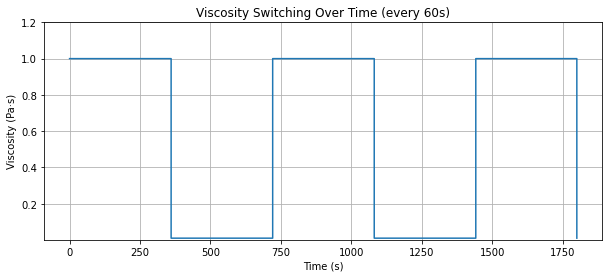

In [6]:
# Generate time values from 0 to 600 seconds
t_values = torch.linspace(0, 1800, steps=1000)
vi_values = get_viscosity(t_values)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(t_values, vi_values, drawstyle='steps-post')
plt.xlabel("Time (s)")
plt.ylabel("Viscosity (Pa·s)")
plt.title("Viscosity Switching Over Time (every 60s)")
plt.grid(True)
plt.ylim(1e-3, 1.2)
plt.show()

In [7]:
# -----------------------------------------------------------------------------
# Training data (collocation + IC + BC)
# -----------------------------------------------------------------------------
a = 8/3.6 # advection speed


T_final = 1800   # seconds
# Pipe length (m)
Pipe_length = 2000

N_f = 200000 # interior collocation points
N_i = 20000     # initial‑condition points
N_b = 500000    # boundary‑condition points

Pipe_diameter = 0.85  # m

# Interior points: (x,t) uniformly sampled in [0, L] x [0, T]
x_f = Pipe_length*torch.rand( N_f, 1, device=device, dtype=torch.float32)
t_f = T_final*torch.rand(N_f,1, device=device)     # <--- scaled by T_final

# Initial condition: t = 0
x_i = Pipe_length*torch.rand(N_i, 1, device=device)
t_i = torch.zeros_like(x_i)
Rho_i = 1
Mu_i = 0.01
P_i = 1
# Boundary condition: x = 0
x_b = torch.zeros(N_b, 1, device=device)
epsilon = 1e-8  # Small value to avoid 0
t_b = T_final * ( torch.rand(N_b, 1, device=device))
Rho_b = get_density(t_b)
Mu_b = get_viscosity(t_b)
x_b_out = torch.full((N_b, 1), Pipe_length, device=device)
P_b = 1

In [8]:
# -----------------------------------------------------------------------------
# Model & optimisers
# -----------------------------------------------------------------------------
Rho = PINN(layers).to(device)
opt_adam = torch.optim.Adam(Rho.parameters(), lr=1e-3)
opt_lbfgs = torch.optim.LBFGS(Rho.parameters(),
                              lr=1.0,
                              max_iter=1000,
                              tolerance_grad=1e-9,
                              tolerance_change=1e-9,
                              history_size=100,
                              line_search_fn="strong_wolfe")


In [9]:

loss_weights = [100, 1, 1]  # Weights used in loss calculation

def loss_components():
    """Returns individual MSE losses: residual, IC, BC."""
    f = pde_residual(Rho, x_f, t_f)
    rho_pred_i = Rho(x_i, t_i)
    rho_pred_b = Rho(x_b, t_b)
    loss_f = torch.mean(f ** 2)
    loss_i = torch.mean((rho_pred_i - Rho_i) ** 2)
    loss_b = torch.mean((rho_pred_b - Rho_b) ** 2)

    return loss_weights[0]*loss_f, loss_weights[1]*loss_i, loss_weights[2]*loss_b

In [10]:
# -----------------------------------------------------------------------------
# Stage 1 – Adam optimisation
# -----------------------------------------------------------------------------

epochs = 8000
start_time = time.time()

for ep in range(epochs):
    # Adam step
    # Compute loss and gradients
    # and update weights
    # with Adam
    # (requires closure function)
    opt_adam.zero_grad()
    lf, li, lb = loss_components()
    loss = lf + li + lb
    loss.backward()
    opt_adam.step()

    if ep % 500 == 0:
        print(f"Adam  {ep:4d}: total={loss.item():.3e}"
              f"(res={lf.item():.1e}, IC={li.item():.1e}, BC={lb.item():.1e})")

# -----------------------------------------------------------------------------
# Stage 2 – L‑BFGS fine‑tuning
# -----------------------------------------------------------------------------

print("Starting L‑BFGS …")

def closure():
    opt_lbfgs.zero_grad()
    lf, li, lb = loss_components()
    loss = lf + li + lb
    loss.backward()
    return loss

opt_lbfgs.step(closure)
print("L‑BFGS complete.")

training_time = time.time() - start_time

print(f"Training time: {training_time:.2f} seconds")
print(f"Final loss: {loss.item():.3e}"
      f"(res={lf.item():.1e}, IC={li.item():.1e}, BC={lb.item():.1e})")


NameError: name 'time' is not defined

In [64]:


def save_training_results(model, losses, weights, training_time):
    """Append training results to CSV file"""
    
    filename = "rho_training_history.csv"
    is_new_file = not os.path.exists(filename)
    
    # Collect training parameters
    results = {
        "Timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "Architecture": "-".join(str(x) for x in layers),
        "Activation": "Tanh",
        "N_interior": N_f,
        "N_initial": N_i,
        "N_boundary": N_b,
        "Pipe_length": Pipe_length,
        "Pipe_diameter": Pipe_diameter,
        "T_final": T_final,
        "Training_time_seconds": training_time,
        "Loss_residual": losses[0].item(),
        "Loss_initial": losses[1].item(),
        "Loss_boundary": losses[2].item(),
        "Weight_residual": weights[0],
        "Weight_initial": weights[1],
        "Weight_boundary": weights[2],
        "Total_loss": sum(l.item()*w for l,w in zip(losses, weights))
    }
    
    # Write to CSV
    with open(filename, 'a', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=results.keys())
        if is_new_file:
            writer.writeheader()
        writer.writerow(results)
    
    print(f"Training results appended to {filename}")



save_training_results(Rho, loss, loss_weights, training_time)

IndexError: invalid index of a 0-dim tensor. Use `tensor.item()` in Python or `tensor.item<T>()` in C++ to convert a 0-dim tensor to a number

In [65]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML



x_line = torch.linspace(0, Pipe_length, 5000, device=device).view(-1, 1)
snapshot_times = torch.arange(0, 3801, 100, device=device)
\
# Set up the figure
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlabel("Position (m)", fontsize=12)
ax.set_ylabel("Density ρ(x,t)", fontsize=12)
ax.set_title("Density Evolution Over Time", fontsize=14)
ax.grid(True, linestyle='--', alpha=0.6)

# Create animation elements
line, = ax.plot([], [], 'b-', linewidth=2)
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, fontsize=12,
                   bbox=dict(facecolor='white', alpha=0.8))

# Set axis limits
ax.set_xlim(0, Pipe_length)
ax.set_ylim(0.8, 1.7)

def init():
    line.set_data([], [])
    time_text.set_text('')
    return line, time_text

def animate(i):
    t_val = snapshot_times[i]
    t_line = t_val.expand_as(x_line)
    
    with torch.no_grad():
        u_pred_line = Rho(x_line, t_line).cpu().numpy().flatten()
    
    line.set_data(x_line.cpu().numpy().flatten(), u_pred_line)
    time_text.set_text(f'Time: {t_val.item():.0f} s')
    
    return line, time_text

# Create animation
ani = animation.FuncAnimation(
    fig, animate, frames=len(snapshot_times),
    init_func=init, blit=True, interval=200
)

plt.close(fig)
HTML(ani.to_jshtml())

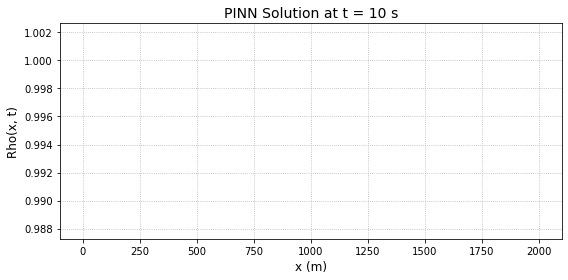

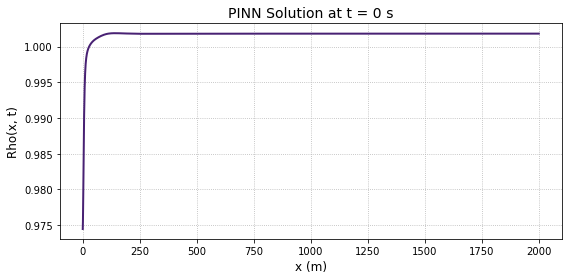

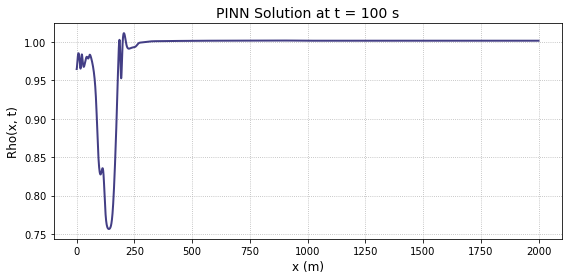

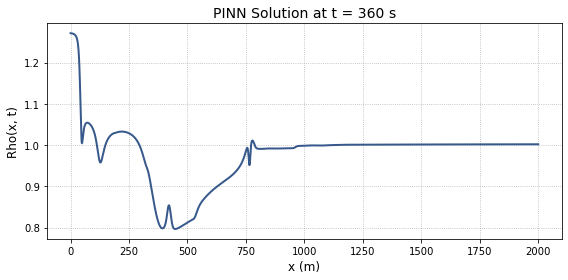

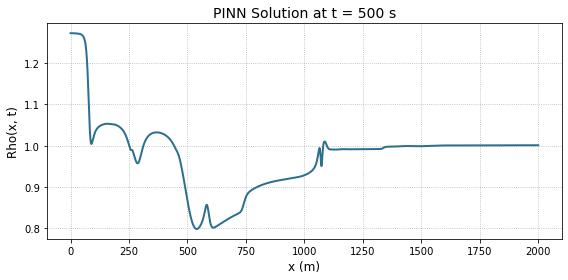

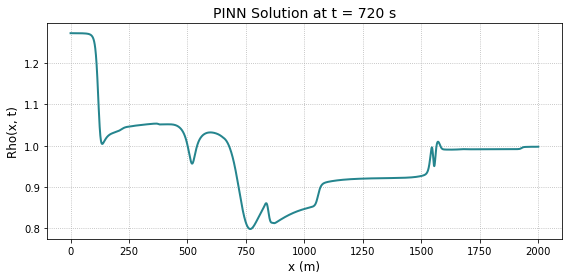

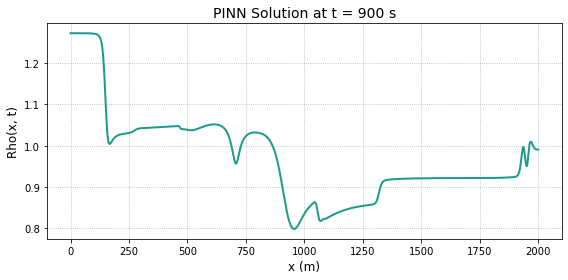

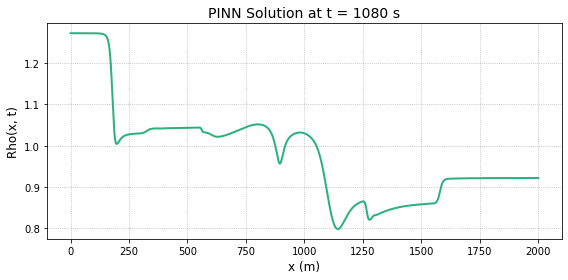

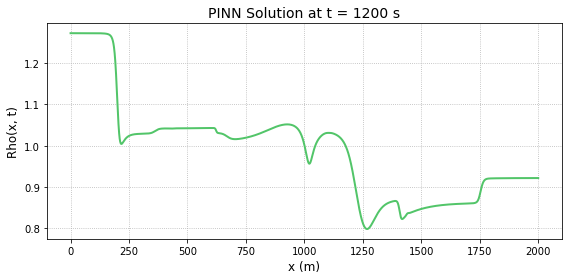

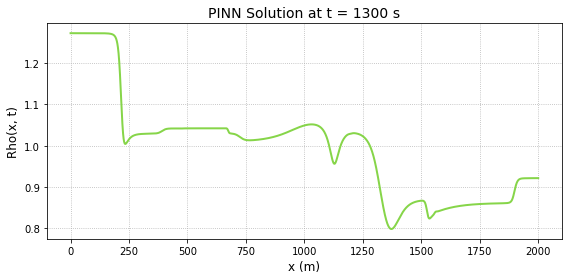

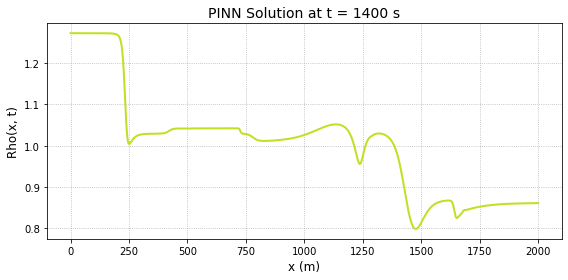

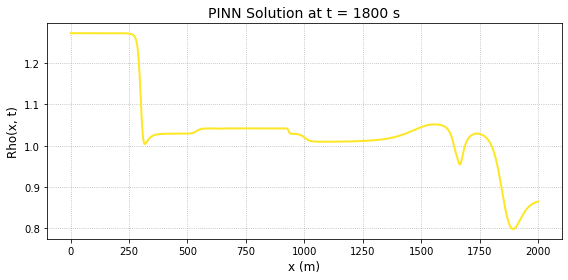

In [66]:
# -----------------------------------------------------------------------------
# Evaluation & Visualisation – separate line plots at each snapshot
# -----------------------------------------------------------------------------

import matplotlib.cm as cm

# Spatial grid for line plots
x_line = torch.linspace(0, Pipe_length, 5000, device=device).view(-1, 1)

# Snapshot times
snapshot_times = torch.tensor([10,0,100,360,500,720,900,1080,1200,1300,1400,1800], device=device)
#snapshot_times = torch.tensor([1080,1200,1300,1400,1800,1800,1900,2000,2200,2400,2600,2800,3000,3200,3400,3600], device=device)

colors = cm.viridis(torch.linspace(0.001, 1, len(snapshot_times)))

for idx, (t_val, color) in enumerate(zip(snapshot_times, colors)):
    t_line = t_val.expand_as(x_line)
    with torch.no_grad():
        u_pred_line = Rho(x_line, t_line).cpu().numpy().flatten()
    plt.figure(figsize=(8, 4))
    plt.plot(x_line.cpu().numpy().flatten(), u_pred_line, color=color, linewidth=2)
    plt.xlabel("x (m)", fontsize=12)
    plt.ylabel("Rho(x, t)", fontsize=12)
    plt.title(f"PINN Solution at t = {t_val.item():.0f} s", fontsize=14)
    plt.grid(True, linestyle=":")
    plt.tight_layout()
    plt.show()

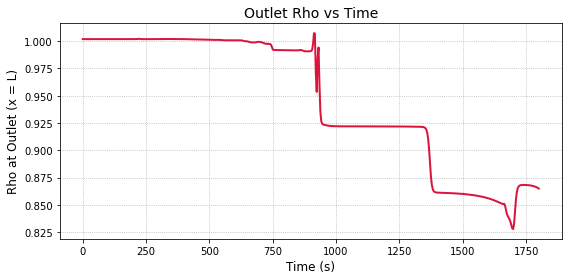

In [69]:
# Plot Rho at the outlet (x = Pipe_length) as a function of time
t_outlet = torch.linspace(0, T_final, 500, device=device).view(-1, 1)
x_outlet = torch.full_like(t_outlet, Pipe_length)

with torch.no_grad():
    rho_outlet = Rho(x_outlet, t_outlet).cpu().numpy().flatten()

plt.figure(figsize=(8, 4))
plt.plot(t_outlet.cpu().numpy().flatten(), rho_outlet, color='crimson', linewidth=2)
plt.xlabel("Time (s)", fontsize=12)
plt.ylabel("Rho at Outlet (x = L)", fontsize=12)
plt.title("Outlet Rho vs Time", fontsize=14)
plt.grid(True, linestyle=":")
plt.tight_layout()
plt.show()

In [ ]:
# -----------------------------------------------------------------------------
# Model & optimisers
# -----------------------------------------------------------------------------
Mu = PINN(layers).to(device)
opt_adam_Mu = torch.optim.Adam(Mu.parameters(), lr=1e-3)
opt_lbfgs_Mu = torch.optim.LBFGS(Mu.parameters(),
                              lr=1.0,
                              max_iter=1000,
                              tolerance_grad=1e-9,
                              tolerance_change=1e-9,
                              history_size=100,
                              line_search_fn="strong_wolfe")

In [ ]:
def loss_components_Mu():
    """Returns individual MSE losses: residual, IC, BC."""
    f = pde_residual(Mu, x_f, t_f)
    Mu_pred_i = Mu(x_i, t_i)
    Mu_pred_b = Mu(x_b, t_b)

    loss_f = torch.mean(f ** 2)
    loss_i = torch.mean((Mu_pred_i - Mu_i) ** 2)
    loss_b = torch.mean((Mu_pred_b - Mu_b) ** 2)
        
    return loss_f, loss_i, loss_b

In [ ]:
# -----------------------------------------------------------------------------
# Stage 1 – Adam optimisation
# -----------------------------------------------------------------------------

epochs = 8000

for ep in range(epochs):
    opt_adam_Mu.zero_grad()
    lf, li, lb = loss_components_Mu()
    loss = lf + li + lb
    loss.backward()
    opt_adam_Mu.step()

    if ep % 500 == 0:
        print(f"Adam  {ep:4d}: total={loss.item():.3e}  "
              f"(res={lf.item():.1e}, IC={li.item():.1e}, BC={lb.item():.1e})")

# -----------------------------------------------------------------------------
# Stage 2 – L‑BFGS fine‑tuning
# -----------------------------------------------------------------------------

print("Starting L‑BFGS …")

def closure():
    opt_lbfgs_Mu.zero_grad()
    lf, li, lb = loss_components_Mu()
    loss = lf + li + lb
    loss.backward()
    return loss

opt_lbfgs_Mu.step(closure)
print("L‑BFGS complete.")


Adam     0: total=1.750e+01  (res=1.6e-06, IC=6.4e-03, BC=1.7e+01)
Adam   500: total=2.245e+00  (res=2.9e-06, IC=1.4e-05, BC=2.2e+00)
Adam  1000: total=2.074e+00  (res=8.4e-06, IC=5.1e-04, BC=2.1e+00)
Adam  1500: total=2.232e+00  (res=9.8e-06, IC=4.2e-05, BC=2.2e+00)
Adam  2000: total=2.448e+00  (res=8.3e-06, IC=7.0e-04, BC=2.4e+00)
Adam  2500: total=2.260e+00  (res=4.8e-06, IC=9.6e-05, BC=2.3e+00)
Adam  3000: total=2.219e+00  (res=9.7e-06, IC=8.2e-06, BC=2.2e+00)
Adam  3500: total=2.218e+00  (res=1.1e-05, IC=2.4e-05, BC=2.2e+00)
Adam  4000: total=2.122e+00  (res=5.1e-06, IC=1.8e-03, BC=2.1e+00)
Adam  4500: total=2.217e+00  (res=9.0e-06, IC=2.2e-05, BC=2.2e+00)
Adam  5000: total=2.029e+00  (res=1.0e-05, IC=3.5e-06, BC=2.0e+00)
Adam  5500: total=2.040e+00  (res=1.2e-05, IC=5.5e-05, BC=2.0e+00)
Adam  6000: total=1.907e+00  (res=9.5e-06, IC=1.6e-04, BC=1.9e+00)
Adam  6500: total=1.632e+00  (res=1.5e-05, IC=7.5e-05, BC=1.6e+00)
Adam  7000: total=1.460e+00  (res=1.6e-05, IC=9.0e-05, BC=1.5e

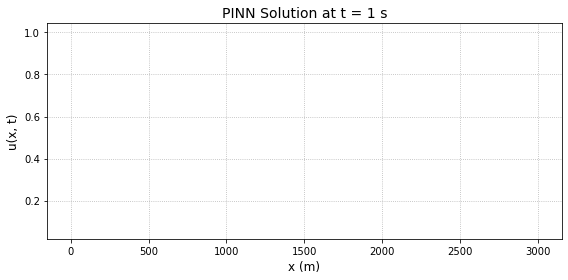

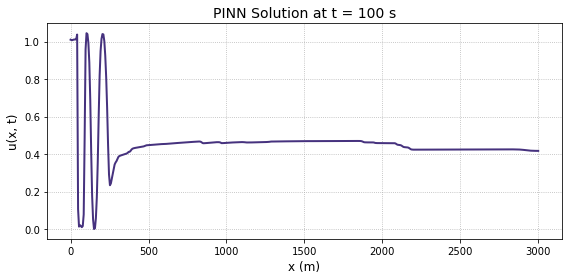

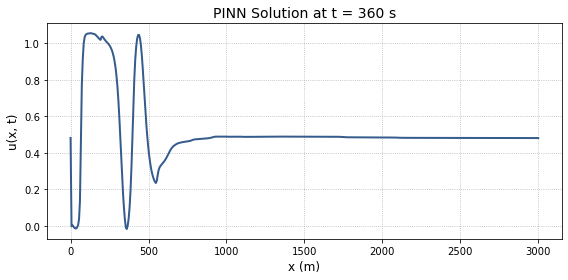

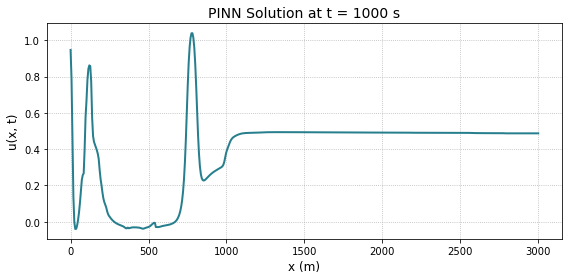

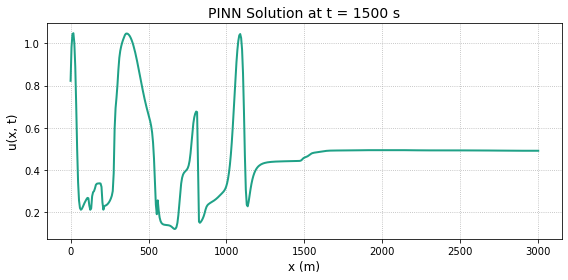

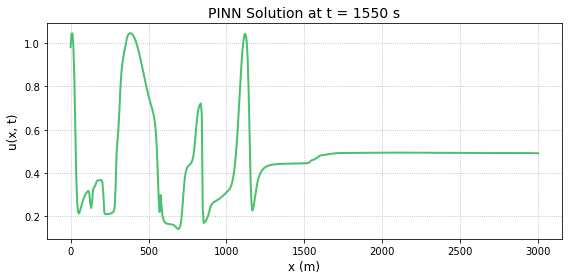

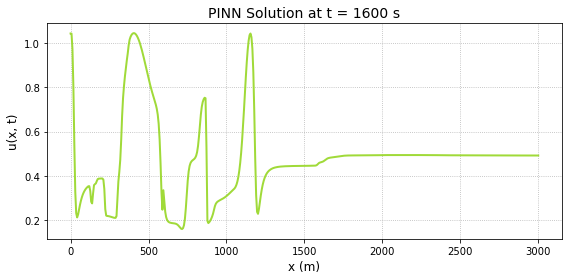

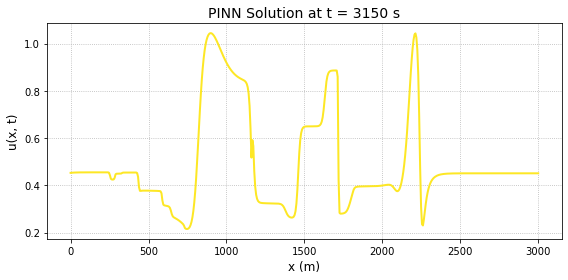

In [ ]:
# -----------------------------------------------------------------------------
# Evaluation & Visualisation – separate line plots at each snapshot
# -----------------------------------------------------------------------------

import matplotlib.cm as cm

# Spatial grid for line plots
x_line = torch.linspace(0, Pipe_length, 500, device=device).view(-1, 1)

# Snapshot times
snapshot_times = torch.tensor([1,100, 360, 1000,1500,1550,1600, 3150], device=device)
colors = cm.viridis(torch.linspace(0.001, 1, len(snapshot_times)))

for idx, (t_val, color) in enumerate(zip(snapshot_times, colors)):
    t_line = t_val.expand_as(x_line)
    with torch.no_grad():
        u_pred_line = Mu(x_line, t_line).cpu().numpy().flatten()
    plt.figure(figsize=(8, 4))
    plt.plot(x_line.cpu().numpy().flatten(), u_pred_line, color=color, linewidth=2)
    plt.xlabel("x (m)", fontsize=12)
    plt.ylabel("u(x, t)", fontsize=12)
    plt.title(f"PINN Solution at t = {t_val.item():.0f} s", fontsize=14)
    plt.grid(True, linestyle=":")
    plt.tight_layout()
    plt.show()

In [ ]:
torch.save(Mu.state_dict(), "Mu.pth")

In [ ]:
# -----------------------------------------------------------------------------
def compute_fd_from_functions(rho_fn, mu_fn, v, x, t, D, epsilon, a=1.0):
    """
    Compute Darcy friction factor f_D over a space-time mesh using input functions.

    Parameters:
        rho_fn (callable): function rho(x, t)
        mu_fn (callable): function mu(x, t)
        v_fn (callable): function v(x, t)
        x (torch.Tensor): 1D tensor of spatial points [nx]
        t (torch.Tensor): 1D tensor of time points [nt]
        D (float): pipe diameter
        epsilon (float): pipe roughness
        a (float): calibration factor

    Returns:
        fD_xt (torch.Tensor): [nx, nt] Darcy friction factor
    """
    X, T = torch.meshgrid(x, t, indexing='ij')  # [nx, nt] each

    # Evaluate rho, mu, v over the mesh
    rho_xt = rho_fn(X, T)*1000
    mu_xt = mu_fn(X, T)/10
    

    # Compute Reynolds number
    Re = (rho_xt * V * D) / mu_xt
    fD_xt = torch.empty_like(Re)
    

    # Laminar regime
    laminar_mask = Re < 2000
    fD_xt[laminar_mask] = 64.0 / Re[laminar_mask]

    # Turbulent regime
    turbulent_mask = ~laminar_mask
    term = epsilon / (3.7 * D) + 5.74 / Re[turbulent_mask]**0.9
    fD_xt[turbulent_mask] = a * (torch.log10(term)) ** (-2)

    return fD_xt


In [ ]:
def F(v,Rho: nn.Module, x: torch.Tensor, t: torch.Tensor,D):

    rho = 1000*Rho(x,t)

    rho_x= rho.autograd.grad(rho, x,
                        grad_outputs=torch.ones_like(rho(x,t)),
                        create_graph=True)[0]
    rho_t= rho.autograd.grad(rho, t,
                        grad_outputs=torch.ones_like(rho(x,t)),
                        create_graph=True)[0]
    f_d= compute_fd_from_functions(rho, Mu, v, x, t, D, 2.13 * 1e-5, a=1.0)

    return (rho_t * v) (rho_x * v**2)+ (f_d * rho * v**2) / (2 * D)



In [ ]:
# -----------------------------------------------------------------------------
# PINN for Pressure: dP/ds + F = 0
# -----------------------------------------------------------------------------

# Define the PINN architecture for pressure
pressure_layers = [2, 128, 128, 128, 1]  # Input: s, Output: P

class PressurePINN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        blocks = []
        for l_in, l_out in zip(layers[:-2], layers[1:-1]):
            blocks.append(nn.Linear(l_in, l_out))
            blocks.append(nn.Tanh())
        blocks.append(nn.Linear(layers[-2], layers[-1]))
        self.model = nn.Sequential(*blocks)
        for m in self.model:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)
    def forward(self, x, t):
        """x, t: tensors of shape (N,1)"""
        input_pair = torch.cat([x, t], dim=1)
        return self.model(input_pair)

In [ ]:
Pressure= PressurePINN(pressure_layers).to(device)
opt_adam_pressure = torch.optim.Adam(Pressure.parameters(), lr=1e-3)
opt_lbfgs_pressure = torch.optim.LBFGS(Pressure.parameters(),
                              lr=1.0,
                              max_iter=1000,
                              tolerance_grad=1e-9,
                              tolerance_change=1e-9,
                              history_size=100,
                              line_search_fn="strong_wolfe")

In [ ]:
# PDE residual: dP/ds + F = 0
def pressure_residual(model,x,t):
    x.requires_grad_(True)
    P = Pressure(x,t)
    P_x = autograd.grad(P, s, grad_outputs=torch.ones_like(P), create_graph=True)[0]
    F = F(a, rho, x, t, Pipe_diameter)
    return P_s + F

In [ ]:
def loss_components():
    """Returns individual MSE losses: residual, IC, BC."""
    f = pde_residual(Pressure, x_f, t_f)
    Pressure_pred_i = Pressure(x_i, t_i)
    Pressure_pred_b = Pressure(x_b_out, t_b)
    # Compute the losses
    loss_f = torch.mean(f ** 2)
    loss_i = torch.mean((Pressure_pred_i - P_i) ** 2)
    loss_b = torch.mean((Pressure_pred_b - P_b) ** 2)
    # Return the losses
    return loss_f, loss_i, 10*loss_b

In [ ]:
# -----------------------------------------------------------------------------
# Stage 1 – Adam optimisation
# -----------------------------------------------------------------------------

epochs = 8000

for ep in range(epochs):
    opt_adam_pressure.zero_grad()
    lf, li, lb = loss_components()
    loss = lf + li + lb
    loss.backward()
    opt_adam_pressure.step()

    if ep % 500 == 0:
        print(f"Adam  {ep:4d}: total={loss.item():.3e}  "
              f"(res={lf.item():.1e}, IC={li.item():.1e}, BC={lb.item():.1e})")

# -----------------------------------------------------------------------------
# Stage 2 – L‑BFGS fine‑tuning
# -----------------------------------------------------------------------------

print("Starting L‑BFGS …")

def closure():
    opt_lbfgs_pressure.zero_grad()
    lf, li, lb = loss_components()
    loss = lf + li + lb
    loss.backward()
    return loss

opt_lbfgs_pressure.step(closure)
print("L‑BFGS complete.")


Adam     0: total=3.265e+01  (res=4.4e-06, IC=1.1e+00, BC=3.2e+01)
Adam   500: total=8.657e-05  (res=2.9e-07, IC=6.2e-05, BC=2.4e-05)
Adam  1000: total=2.428e-05  (res=2.9e-07, IC=1.3e-05, BC=1.1e-05)
Adam  1500: total=1.975e-05  (res=2.8e-07, IC=1.2e-05, BC=7.5e-06)
Adam  2000: total=1.624e-05  (res=2.8e-07, IC=1.1e-05, BC=4.8e-06)
Adam  2500: total=1.381e-05  (res=2.7e-07, IC=1.0e-05, BC=3.3e-06)
Adam  3000: total=1.198e-05  (res=2.7e-07, IC=9.2e-06, BC=2.6e-06)
Adam  3500: total=1.133e-05  (res=2.3e-07, IC=7.9e-06, BC=3.2e-06)
Adam  4000: total=9.908e-06  (res=2.0e-07, IC=6.9e-06, BC=2.8e-06)
Adam  4500: total=7.939e-06  (res=1.7e-07, IC=6.1e-06, BC=1.6e-06)
Adam  5000: total=6.932e-06  (res=1.5e-07, IC=5.3e-06, BC=1.5e-06)
Adam  5500: total=5.672e-06  (res=7.9e-08, IC=4.4e-06, BC=1.2e-06)
Adam  6000: total=4.573e-06  (res=6.6e-08, IC=3.6e-06, BC=8.9e-07)
Adam  6500: total=6.613e-03  (res=5.6e-08, IC=8.3e-05, BC=6.5e-03)
Adam  7000: total=4.879e-06  (res=5.3e-08, IC=2.5e-06, BC=2.3e

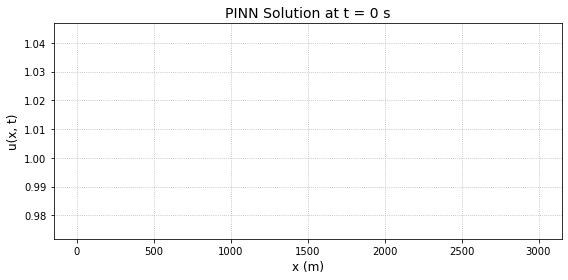

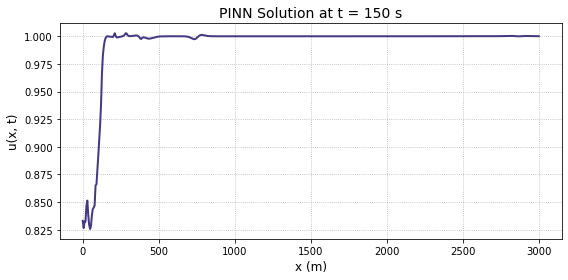

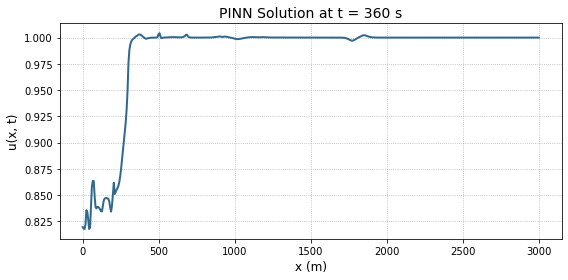

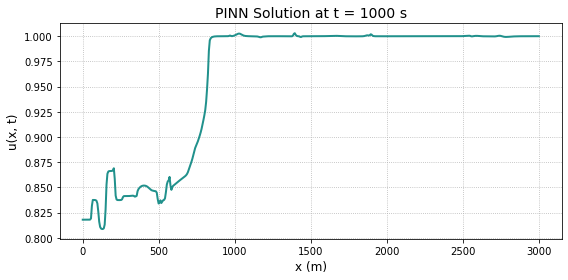

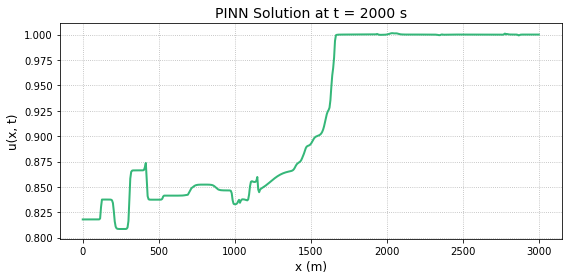

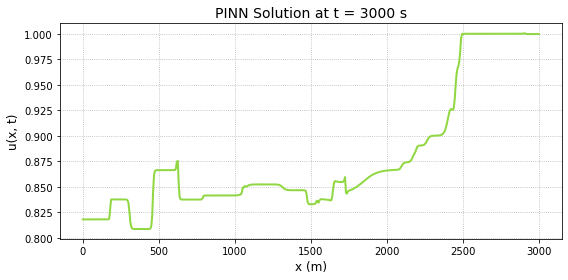

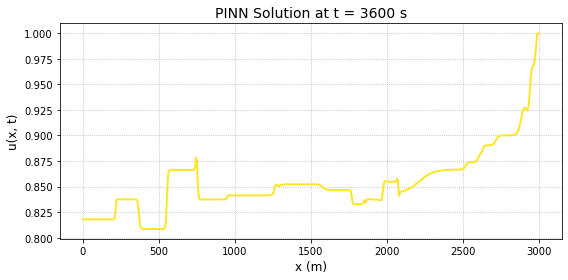

In [ ]:
# -----------------------------------------------------------------------------
# Evaluation & Visualisation – separate line plots at each snapshot
# -----------------------------------------------------------------------------

import matplotlib.cm as cm

# Spatial grid for line plots
x_line = torch.linspace(0, Pipe_length, 500, device=device).view(-1, 1)
# Time values for line plots
t_values = torch.tensor([0, 150, 360, 1000, 2000, 3000, 3600], device=device)
# Snapshot times
colors = cm.viridis(torch.linspace(0.001, 1, len(snapshot_times)))

for idx, (t_val, color) in enumerate(zip(snapshot_times, colors)):
    t_line = t_val.expand_as(x_line)
    with torch.no_grad():
        u_pred_line = Pressure(x_line, t_line).cpu().numpy().flatten()
    plt.figure(figsize=(8, 4))
    plt.plot(x_line.cpu().numpy().flatten(), u_pred_line, color=color, linewidth=2)
    plt.xlabel("x (m)", fontsize=12)
    plt.ylabel("u(x, t)", fontsize=12)
    plt.title(f"PINN Solution at t = {t_val.item():.0f} s", fontsize=14)
    plt.grid(True, linestyle=":")
    plt.tight_layout()
    plt.show()

In [74]:
!nvidia-smi

Wed May 21 11:19:18 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.216.03             Driver Version: 535.216.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  | 00000000:C1:00.0 Off |                    0 |
| N/A   26C    P0              69W / 500W |  10402MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
!kill -9 1807114  


: 

: 

: 

In [ ]:
!nvidia-smi


Tue May 20 20:22:49 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.216.03             Driver Version: 535.216.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  | 00000000:01:00.0 Off |                    0 |
| N/A   28C    P0              56W / 500W |      0MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--